In [1]:
import sys
sys.path.append("models/raster")

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from auxiliary.visualization import visualize_losses, visualize_multiple_losses
from auxiliary.misc import send_notification, get_model_name

from dataset_raster import BuildingRasterDataset
from train_raster import train_raster_model
from initialize_raster import initialize_raster_model

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    raster_path = "../scratch/raster"
else:
    device = torch.device("cpu")
    # local path
    raster_path = "../data.nosync/raster"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

# operators for the elimination models
elimination_operators = ["elimination"]

# operators for the selection models
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]

In [5]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

In [6]:
def load_training_validation_raster_dataset(operator_model, operators_to_predict, attach_roads, subset):
    '''Loads the training and validation dataset associated for the given model.'''
    # define path to training and validation data
    path_to_training_data = os.path.join(raster_path, "training_data", operator_model, "training")
    path_to_validation_data = os.path.join(raster_path, "training_data", operator_model, "validation")

    # composing various random transforms that should be applied to the data
    transform = transforms.Compose([
        transforms.RandomChoice([
            transforms.RandomRotation(degrees=(0,0)),
            transforms.RandomRotation(degrees=(90,90)),
            transforms.RandomRotation(degrees=(180,180)),
            transforms.RandomRotation(degrees=(270,270))
        ]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5)
    ])
    
    # construct training Dataset
    training_set = BuildingRasterDataset(path_to_training_data, 
                                         operators=operators_to_predict, 
                                         attach_roads=attach_roads, 
                                         transform=transform, 
                                         subset=subset)
    
    # construct validation Dataset (no shuffling)
    validation_set = BuildingRasterDataset(path_to_validation_data, 
                                           operators=operators_to_predict, 
                                           attach_roads=attach_roads, 
                                           transform=transform,
                                           subset=subset)
    
    return training_set, validation_set
    
def conduct_raster_model_training(architecture, operator_model, attach_roads, n_epochs, batch_size, device, subset=None):
    '''Given an architecture, model and further parameters, conducts a full training routine of the raster model.
    The loss history and the model are saved to disk.'''
    assert operator_model in ("elimination", "selection")
    assert architecture in ("cnn", "vit")

    if operator_model == "elimination":
        operators_to_predict = elimination_operators
    elif operator_model == "selection":
        operators_to_predict = selection_operators

    # load training and validation data
    training_set, validation_set = load_training_validation_raster_dataset(operator_model, operators_to_predict, attach_roads, subset)    
    print(f"{len(training_set):,} samples in the training set.")
    print(f"{len(validation_set):,} samples in the validation set.")

    # initialize model
    model = initialize_raster_model(architecture, operators_to_predict, attach_roads)
    model.to(device)
    print(f"Using {model}")

    # get loss function and optimizer
    learning_rate = 0.0005
    criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # training the model
    model, training_losses, validation_losses, training_time = train_raster_model(model=model, 
                                                                                  device=device, 
                                                                                  optimizer=optimizer, 
                                                                                  criterion=criterion, 
                                                                                  n_epochs=n_epochs, 
                                                                                  batch_size=batch_size, 
                                                                                  validate=True, 
                                                                                  training_set=training_set, 
                                                                                  validation_set=validation_set, 
                                                                                  shuffle_training_set=True, 
                                                                                  shuffle_validation_set=False)
    
    # get a unique model name
    model_name = get_model_name(model, ops=operator_model[:3], attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, 
                                batch_size=batch_size, device=device)
    
    # saving the losses
    model_name_csv = model_name + ".csv"
    losses_path = os.path.join(raster_path, "model_outputs", operator_model, "losses", model_name_csv)
    
    # creating a DataFrame with loss values
    losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                              "training_loss": training_losses, 
                              "validation_loss": validation_losses})
    
    # save to CSV
    losses_df.to_csv(losses_path, index=False)
    
    # if working on ScienceCluster, send notification that training has finished
    if torch.cuda.is_available():
        send_notification(model=model, 
                          email_address="joris.senn@uzh.ch", 
                          n_samples=len(training_set), 
                          n_epochs=n_epochs, 
                          batch_size=batch_size, 
                          time=training_time)
    
    # save the trained model to disk
    path_to_models = os.path.join(raster_path, "models", operator_model)
    model_name_pth = model_name + ".pth"
    torch.save({"epoch": n_epochs,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": criterion,
                }, os.path.join(path_to_models, model_name_pth))

    # visualize the loss curve of the trained model
    loss_path = os.path.join(raster_path, "model_outputs", operator_model, "losses")
    visualize_losses(model_name_csv, loss_path)

## Elimination model

In [7]:
# architecture: CNN or ViT
architecture = "vit"
# define whether roads should be attached
attach_roads = True
# number of epochs
n_epochs = 2
# batch size to use for training
batch_size = 16

assert architecture in ("cnn", "vit")

1,000 samples in the training set.
1,000 samples in the validation set.
Using Vision Transformer with 20,586,241 parameters
epoch 1/2, step 6/63
epoch 1/2, step 12/63
epoch 1/2, step 18/63
epoch 1/2, step 24/63
epoch 1/2, step 30/63
epoch 1/2, step 36/63
epoch 1/2, step 42/63
epoch 1/2, step 48/63
epoch 1/2, step 54/63
epoch 1/2, step 60/63
epoch 1 finished, training loss: 0.721, validation loss: 0.695
epoch 2/2, step 6/63
epoch 2/2, step 12/63
epoch 2/2, step 18/63
epoch 2/2, step 24/63
epoch 2/2, step 30/63
epoch 2/2, step 36/63
epoch 2/2, step 42/63
epoch 2/2, step 48/63
epoch 2/2, step 54/63
epoch 2/2, step 60/63
epoch 2 finished, training loss: 0.701, validation loss: 0.694
Training time: 38.747 seconds


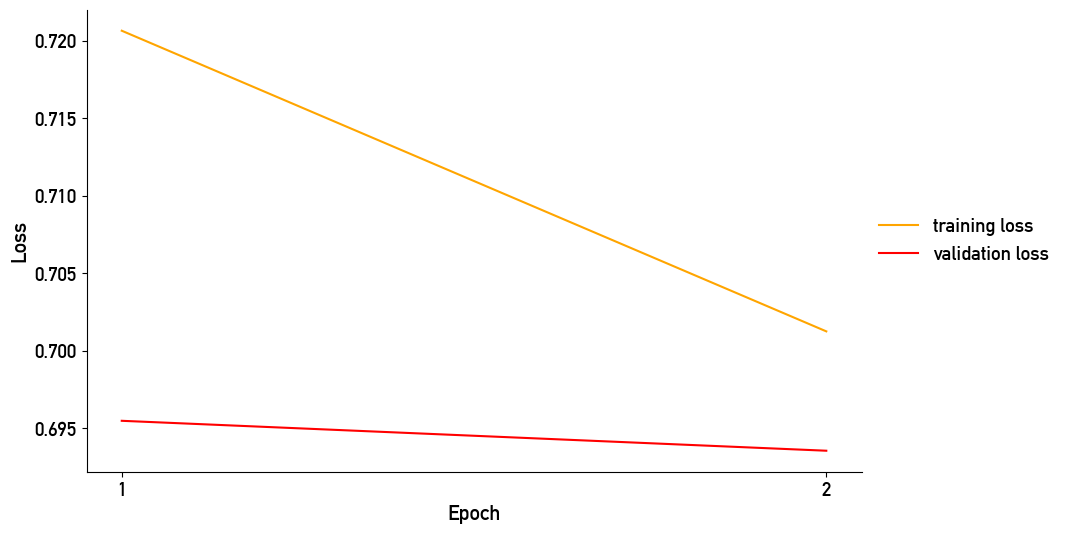

In [8]:
# conduct raster model training according to specifications
conduct_raster_model_training(architecture=architecture, 
                              operator_model="elimination", 
                              attach_roads=attach_roads, 
                              n_epochs=n_epochs, 
                              batch_size=batch_size, 
                              device=device, 
                              subset=1000)

## Selection model

In [9]:
# architecture: CNN or ViT
architecture = "vit"
# define whether roads should be attached
attach_roads = True
# number of epochs
n_epochs = 2
# batch size to use for training
batch_size = 16

assert architecture in ("cnn", "vit")

1,000 samples in the training set.
1,000 samples in the validation set.
Using Vision Transformer with 20,783,620 parameters
epoch 1/2, step 6/63
epoch 1/2, step 12/63
epoch 1/2, step 18/63
epoch 1/2, step 24/63
epoch 1/2, step 30/63
epoch 1/2, step 36/63
epoch 1/2, step 42/63
epoch 1/2, step 48/63
epoch 1/2, step 54/63
epoch 1/2, step 60/63
epoch 1 finished, training loss: 0.704, validation loss: 0.685
epoch 2/2, step 6/63
epoch 2/2, step 12/63
epoch 2/2, step 18/63
epoch 2/2, step 24/63
epoch 2/2, step 30/63
epoch 2/2, step 36/63
epoch 2/2, step 42/63
epoch 2/2, step 48/63
epoch 2/2, step 54/63
epoch 2/2, step 60/63
epoch 2 finished, training loss: 0.683, validation loss: 0.674
Training time: 41.924 seconds


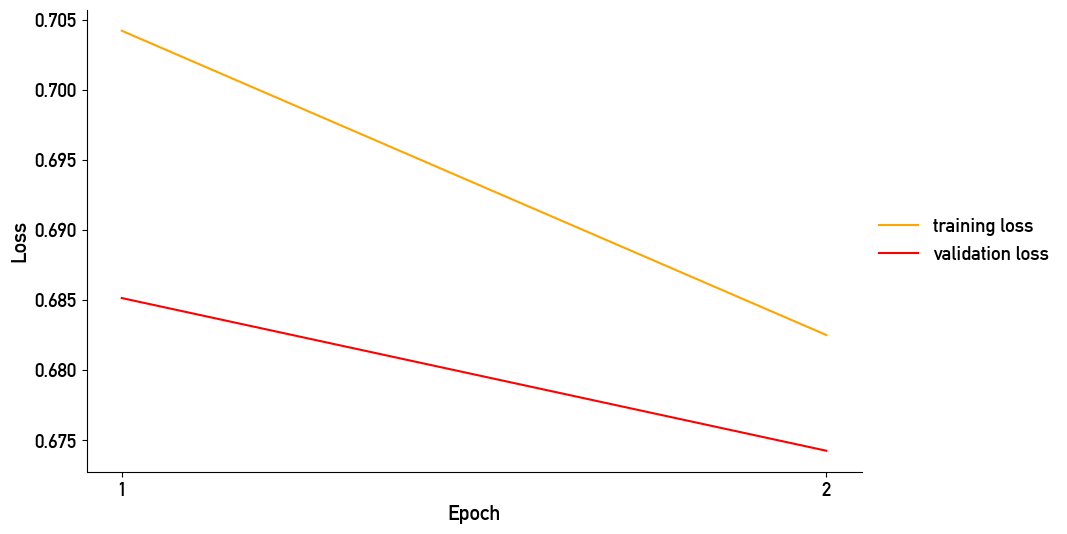

In [10]:
# conduct raster model training according to specifications
conduct_raster_model_training(architecture=architecture, 
                              operator_model="selection", 
                              attach_roads=attach_roads, 
                              n_epochs=n_epochs, 
                              batch_size=batch_size, 
                              device=device, 
                              subset=1000)

## Loss curves of raster models

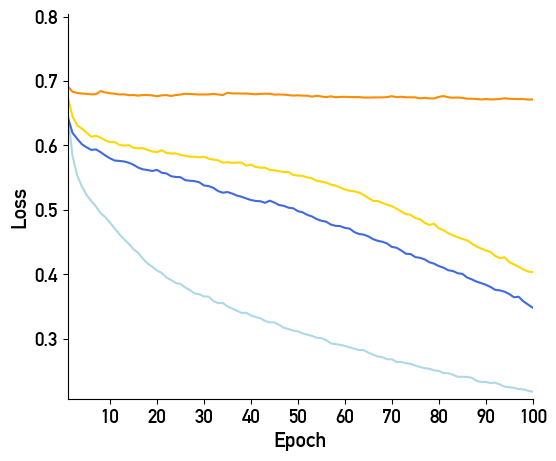

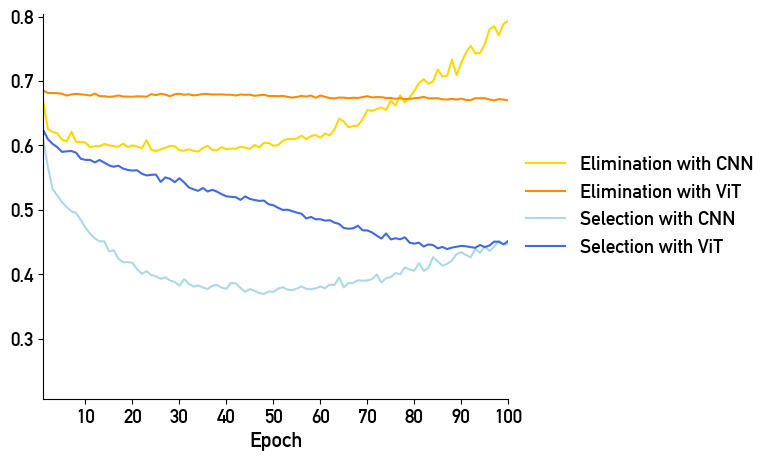

In [11]:
# loss path
model_losses = ["CNN_eli_attachRoadsTrue_4075585p_100000s_100ep_bs512_cuda.csv",
                "ViT_eli_attachRoadsTrue_20586241p_100000s_100ep_bs512_cuda.csv",
                "CNN_sel_attachRoadsTrue_8893252p_100000s_100ep_bs512_cuda.csv",
                "ViT_sel_attachRoadsTrue_20783620p_100000s_100ep_bs512_cuda.csv"]

visualize_multiple_losses(model_losses, 
                          path_to_data="../data.nosync", 
                          model="raster", 
                          epochs_every=10,
                          figsize=(6,5), 
                          save=True, 
                          output_path="../../Figures/Results/losses")